# ARIMA + Boosting

## Intuition

Combining the method of time-series ARIMA regression to have a feature matrix. And I tried different boosting classification methods to find the class that the next time period belongs to, and fit back to arima make forecast. Since the feature matrix contains a lot of NaN entries, which is unavioidable, so I use the Gradient Boosting algorithm which could handling NaN entries. The accuracy score is based on the boosting methods, in which the predicting value is categorical.

Reference paper: [Time series classification based on arima and
adaboost](https://www.matec-conferences.org/articles/matecconf/pdf/2020/05/matecconf_cscns2020_03024.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoCV, ElasticNetCV, ElasticNet
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, classification_report, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import matplotlib.dates as mdates
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm
import itertools
from pmdarima import ARIMA, auto_arima
import warnings
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from statsmodels.tsa.arima.model import ARIMA
# import ssl
import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
# ssl._create_default_https_context = ssl._create_unverified_context
# url = 'https://raw.githubusercontent.com/AS2357/ADA-dataset/refs/heads/project/project%20data%20updated.csv'
df = pd.read_excel('/Users/apple/Desktop/ECOM90025/project/data/Untitled spreadsheet.xlsx', index_col='time', parse_dates=True)
df.drop(columns=['unemployment_rate'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 306 entries, 1999-03-01 to 2024-08-01
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Cash_rate                                  306 non-null    float64
 1   inflation_rate                             306 non-null    float64
 2   CPI                                        306 non-null    float64
 3   lag4 cash rate                             306 non-null    float64
 4   lag3 cash rate                             306 non-null    float64
 5   lag2 cash rate                             306 non-null    float64
 6   lag1 cash rate                             306 non-null    float64
 7   hourly_wage_growth                         306 non-null    float64
 8   Bank_Prime_Loan_rate                       306 non-null    float64
 9    labor_market_condition_index              306 non-null    float64
 10  USD-AUD

In [35]:
X = df.drop(columns=['Cash_rate', 'CPI'])
for i in range(1, 6):
    X[f'Trade_balance_lag_{i}'] = X['Trade_balance'].shift(i)
    
for i in range(1, 6):
    X[f'inflation_rate_lag_{i}'] = X['inflation_rate'].shift(i)

y = df['Cash_rate']

df_update = pd.concat([X, y], axis=1)
info = df_update.info()

num_bins = 5

# Bin the continuous values into discrete categories
y_binned = pd.cut(y, bins=num_bins, labels=False)

train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 306 entries, 1999-03-01 to 2024-08-01
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   inflation_rate                             306 non-null    float64
 1   lag4 cash rate                             306 non-null    float64
 2   lag3 cash rate                             306 non-null    float64
 3   lag2 cash rate                             306 non-null    float64
 4   lag1 cash rate                             306 non-null    float64
 5   hourly_wage_growth                         306 non-null    float64
 6   Bank_Prime_Loan_rate                       306 non-null    float64
 7    labor_market_condition_index              306 non-null    float64
 8   USD-AUD_exchange_rate                      306 non-null    float64
 9   deposit&foreign_related_institution        306 non-null    float64
 10  M2     

# Data

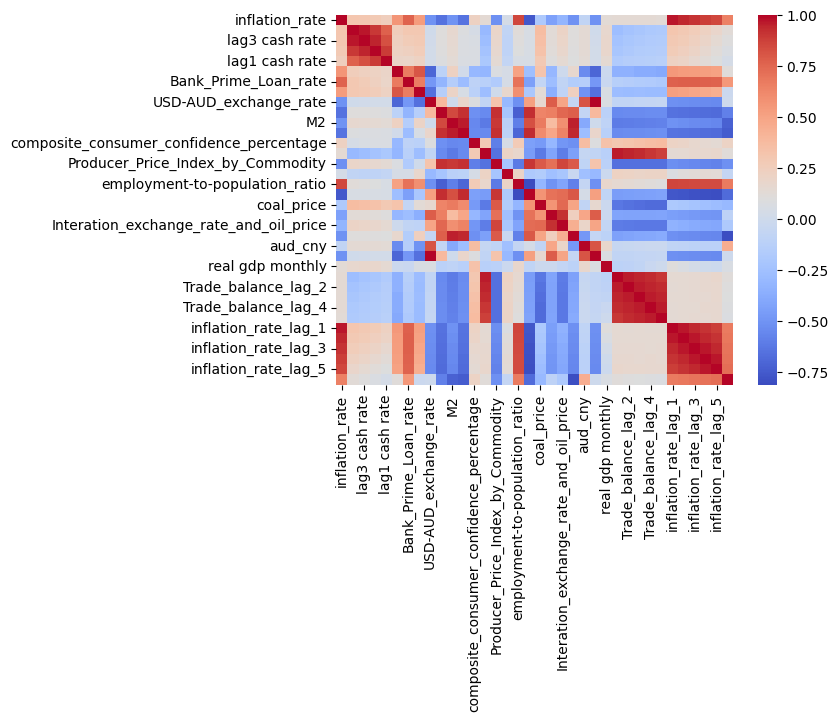

In [37]:
# correlation matrix
corr = df_update.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

In [36]:
# 1 lag all variables in X
# X_lagged = X.shift(1)
# X_lagged['Cash_rate'] = y.shift(1)
# X_lagged.dropna(inplace=True)

# # correlation of all variables in X_lagged to Cash_rate in numbers
# corr_lag = X_lagged.corr()
# print(corr_lag['Cash_rate'])

# Concatenate y to X
X_with_y = X.copy()
X_with_y['Cash_rate'] = y

# Calculate the correlation matrix
corr = X_with_y.corr()

# Print the correlation of all variables in X with 'Cash_rate'
print(corr['Cash_rate'])





inflation_rate                               0.649368
lag4 cash rate                               0.128430
lag3 cash rate                               0.100094
lag2 cash rate                               0.069759
lag1 cash rate                               0.037826
hourly_wage_growth                           0.114593
Bank_Prime_Loan_rate                         0.551998
 labor_market_condition_index               -0.020984
USD-AUD_exchange_rate                       -0.006895
deposit&foreign_related_institution         -0.588184
M2                                          -0.721959
Financial_Market: Share_Prices              -0.746093
composite_consumer_confidence_percentage     0.212051
Trade_balance                                0.120837
Producer_Price_Index_by_Commodity           -0.518219
Business_Investment_And_Sentiment           -0.062977
employment-to-population_ratio               0.668054
Interaction_exchange_rate_and_share_price   -0.680831
coal_price                  

## ARIMA

In [133]:
d = range(0, 2)
p = range(1,6)
q = range(0, 4)

pdq = list(itertools.product(p, d, q))
def extract_arima_features(series, pdq):
    best_aic = np.inf
    best_pdq = None
    best_model = None
    for param in pdq:
        try:
            model = ARIMA(series, order=param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_model = results
        except:
            continue
    return best_model.params

In [134]:
arima_features = []
for i in range(len(X)):
    features = extract_arima_features(X.iloc[i], pdq)
    arima_features.append(features)

In [135]:
arima_features = pd.DataFrame(arima_features)

#  Train the Gradient Boosting Classifier

In [136]:
# Define the number of bins
num_bins = 6 # I've tried different values here, find 6 to be the best considering the accuracy score

# Bin the continuous values into discrete categories
y_binned = pd.cut(y, bins=num_bins, labels=False)

X_train, X_test, y_train, y_test = train_test_split(arima_features, y_binned, test_size=0.2, random_state=42)

In [137]:
hist_gb = HistGradientBoostingClassifier()
hist_gb.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [138]:
# Make predictions on the test set
y_pred = hist_gb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy (out of sample) : {accuracy}')

# Make in-sample predictions on the training set
y_train_pred = hist_gb.predict(X_train)

# Evaluate the in-sample prediction score
in_sample_accuracy = accuracy_score(y_train, y_train_pred)
print(f'In-Sample Accuracy: {in_sample_accuracy}')

Accuracy (out of sample) : 0.7903225806451613
In-Sample Accuracy: 1.0


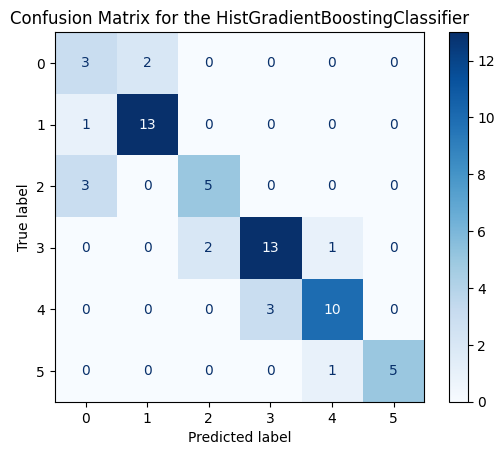

In [139]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_binned))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for the HistGradientBoostingClassifier")
plt.show()

## Prediction

In [140]:
# Extract ARIMA features for the last observation
last_observation_features = extract_arima_features(X.iloc[-1], pdq)

# Convert to DataFrame to ensure feature names are consistent
last_observation_features_df = pd.DataFrame([last_observation_features], columns=arima_features.columns)

In [141]:
# Classify the last observation
last_observation_class = hist_gb.predict(last_observation_features_df)[0]
print(f"Class of the last observation: {last_observation_class}")

Class of the last observation: 3


In [142]:
# Add the predicted class labels to the original DataFrame
df['Predicted_Class'] = hist_gb.predict(arima_features)

def fit_and_predict_arima(series, steps=5):
    best_model = fit_arima_model(series, pdq)
    forecast = best_model.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()
    return forecast_values, forecast_conf_int

class_predictions = {}

# Fit ARIMA model and make predictions for each class
for class_label in df['Predicted_Class'].unique():
    class_series = df[df['Predicted_Class'] == class_label]['Cash_rate']
    forecast_values, forecast_conf_int = fit_and_predict_arima(class_series)
    class_predictions[class_label] = (forecast_values, forecast_conf_int)

In [143]:
# Get the time series data for the classified class
class_series = df[df['Predicted_Class'] == last_observation_class]['Cash_rate']

# Fit ARIMA model and make one-step ahead prediction
forecast_values, forecast_conf_int = fit_and_predict_arima(class_series, steps=1)

In [144]:
def qy_customed(x):
    return round((x - 0.1) / 0.25) * 0.25 + 0.1

forecast_values = forecast_values.apply(qy_customed)
forecast_conf_int = forecast_conf_int.applymap(qy_customed)

In [145]:
print(f"One-Step Ahead Forecast for Class {last_observation_class}:")
print("Forecast Value:")
print(forecast_values.values[0])
print("Confidence Interval:")
print(forecast_conf_int.values[0])

One-Step Ahead Forecast for Class 3:
Forecast Value:
4.35
Confidence Interval:
[4.1 4.6]
